In [33]:
#Importar las librerías por utilizar
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
from skimage import io
from skimage.transform import probabilistic_hough_line
from skimage.filters import threshold_otsu,sobel,sobel_v,sobel_h
from skimage.feature import canny
from skimage.color import rgb2hsv,rgb2gray
from skimage.draw import circle_perimeter
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from matplotlib import cm

#Obtener la direccion de las imagenes
path = os.getcwd()

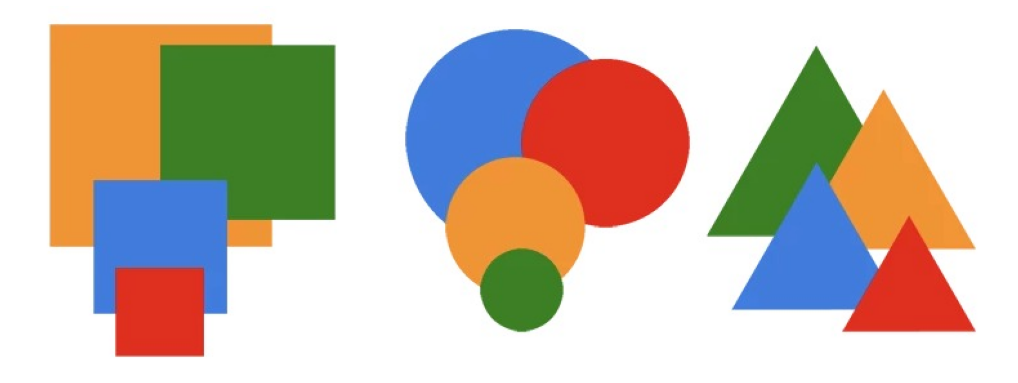

tamaño: (287, 780, 3)


In [11]:
#Imagen original
file_path = os.path.join(path , 'Imagen_a_utilizar.jpeg')
img_org = io.imread(file_path)
shape = img_org.shape

plt.figure(figsize = (18,24))
plt.imshow(img_org)
plt.axis('off')
plt.show()
print('tamaño: ' + str(img_org.shape))

In [12]:
#PARAMETROS

#numero de colores incluyendo el fondo
N_COLORS = 5

#suma minima del fondo (blanco)
SUM_WHITE = 762 

# 8-vecindad
VECINDAD = [
    (-1,-1), (-1, 0), (-1, 1),
    ( 0,-1),          ( 0, 1),
    ( 1,-1), ( 1, 0), ( 1, 1)]

#Maxima desviacion de color (condicion de similitud)
MAX_SUM_COLOR = 30

#Numero de semillas para segmentar por color
N_SEEDS = 500


In [13]:
#Quantificacion 4 colores
#https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

def img_to_5_colors(img):
    # Copia de la imagen por cuantificar
    img_5_colors = img

    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    img_5_colors = np.array(img_5_colors, dtype=np.float64) / 255

    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(img_5_colors.shape)
    assert d == 3
    image_array = np.reshape(img_5_colors, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=N_COLORS, random_state=0).fit(image_array_sample)
    colores = np.rint(np.array(kmeans.cluster_centers_, dtype=np.float64) *255)
    colores = colores.tolist()
    for color in colores:
        if color[0]+color[1]+color[2] >= SUM_WHITE:
            colores.remove(color)
    colores = np.array(colores,dtype=np.int32)
    return colores

COLORES=img_to_5_colors(img_org)
print(COLORES)


[[ 69 124 216]
 [237 150  60]
 [ 63 127  39]
 [221  48  33]]


In [14]:
# Crecimiento de region

# Condicion de similitud
def simililares(pix,color):
    sum = abs(pix[0]-color[0])+abs(pix[1]-color[1])+abs(pix[2]-color[2])
    return sum < MAX_SUM_COLOR

def region_growth(seed,img,out_img,visitado):  
    h, w = shape[:2]
    region = [seed]
    # Identifica el color de la semilla si no esta visitada
    x = seed[0]
    y = seed[1]
    seed_color = np.zeros((3),dtype=np.uint16)
    if (not visitado[y][x]):
        for COLOR in COLORES:
            if simililares(img[y][x],COLOR):
                seed_color = COLOR
                out_img[y][x] = seed_color
    else:
        seed_color = np.zeros((3),dtype=np.uint16)
        return out_img,seed_color
    # Crecimiento de la región
    while len(region):
        seed = region.pop(0)
        x = seed[0]
        y = seed[1]
        # Marca la semilla como visitada
        visitado[y][x] = 1
        for vecino in VECINDAD:
            cur_x = x + vecino[0]
            cur_y = y + vecino[1]
            # limites de la imagen
            if cur_x <0 or cur_y<0 or cur_x >= w or cur_y >=h :
                continue
            # crea nueva semilla si el pixel actual es similar a la semilla
            # y si aun no está visitado, marca pixel actual como visitado
            if (not visitado[cur_y][cur_x]) and simililares(img[cur_y][cur_x],seed_color):
                out_img[cur_y][cur_x] = seed_color
                visitado[cur_y][cur_x] = 1
                region.append((cur_x,cur_y))
    return out_img,seed_color


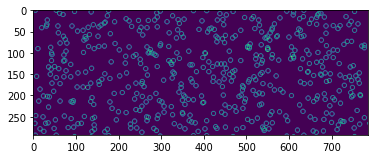

In [15]:
#Generacion de semillas

def generate_seeds():
    seeds = np.zeros((N_SEEDS,2), dtype=np.uint16)
    for i in range(N_SEEDS):
        seeds[i][0] = np.random.randint(0,shape[1])
        seeds[i][1] = np.random.randint(0,shape[0])
    return seeds

SEEDS=generate_seeds()

seeds_img = np.zeros((shape[0]+6,shape[1]+6), dtype=np.uint8)
for seed in SEEDS:
    rr, cc = circle_perimeter(np.uint16(seed[1]), np.uint16(seed[0]), 5)
    seeds_img[rr,cc] = 1
plt.imshow(seeds_img)
plt.show()

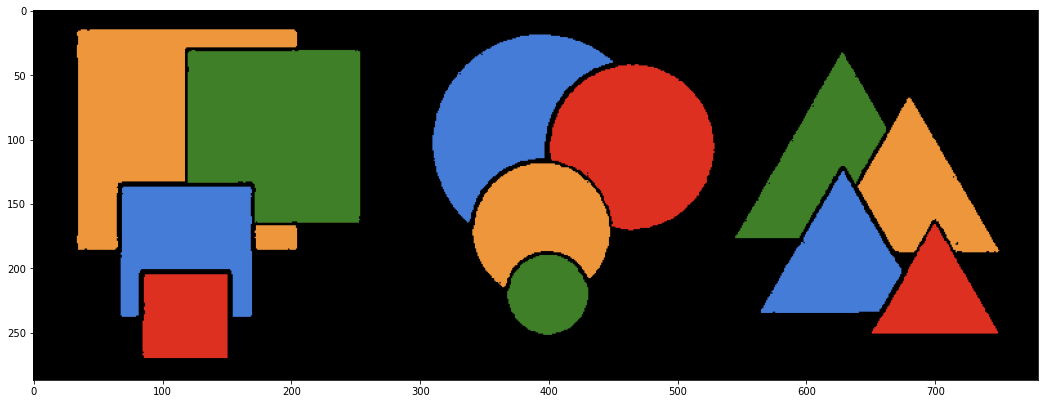

In [16]:
#Segmentacion por color

#eliminar imagenes vacias
def clean_list_by_color(regs,regs_clr):
    indexes = []
    for i in range(N_SEEDS):
        if regs_clr[i].all() != 0:
            indexes.append(i)
    new_regs = np.zeros((len(indexes),shape[0],shape[1],shape[2]), dtype=np.int32)
    new_regs_clr = np.zeros((len(indexes),3), dtype=np.uint8)
    for i in range(len(indexes)):
        new_regs[i] = regs[indexes[i]]
        new_regs_clr[i] = regs_clr[indexes[i]]
    return new_regs,new_regs_clr

#Segmentacion por color
def segmentacion_por_color(img):
    SEEDS=generate_seeds()
    regions = np.zeros((N_SEEDS,shape[0],shape[1],shape[2]), dtype=np.int32)
    regions_colors = np.zeros((N_SEEDS,3), dtype=np.uint8)
    visitado = np.zeros(shape=(shape[0],shape[1],1), dtype=np.uint8)
    for i in range(N_SEEDS):
        out_img_temp = np.zeros(shape=shape, dtype=np.uint8)
        regions[i],regions_colors[i] = region_growth(SEEDS[i],img,out_img_temp,visitado)
    return clean_list_by_color(regions, regions_colors)
    
    

regs,regs_clr = segmentacion_por_color(img_org)
img_sum = np.zeros(shape=(shape[0],shape[1],3), dtype=np.uint8)
for i in range(regs_clr.shape[0]):
    img_sum = img_sum + regs[i]
plt.figure(figsize = (18,24))
plt.imshow(img_sum)
plt.show()

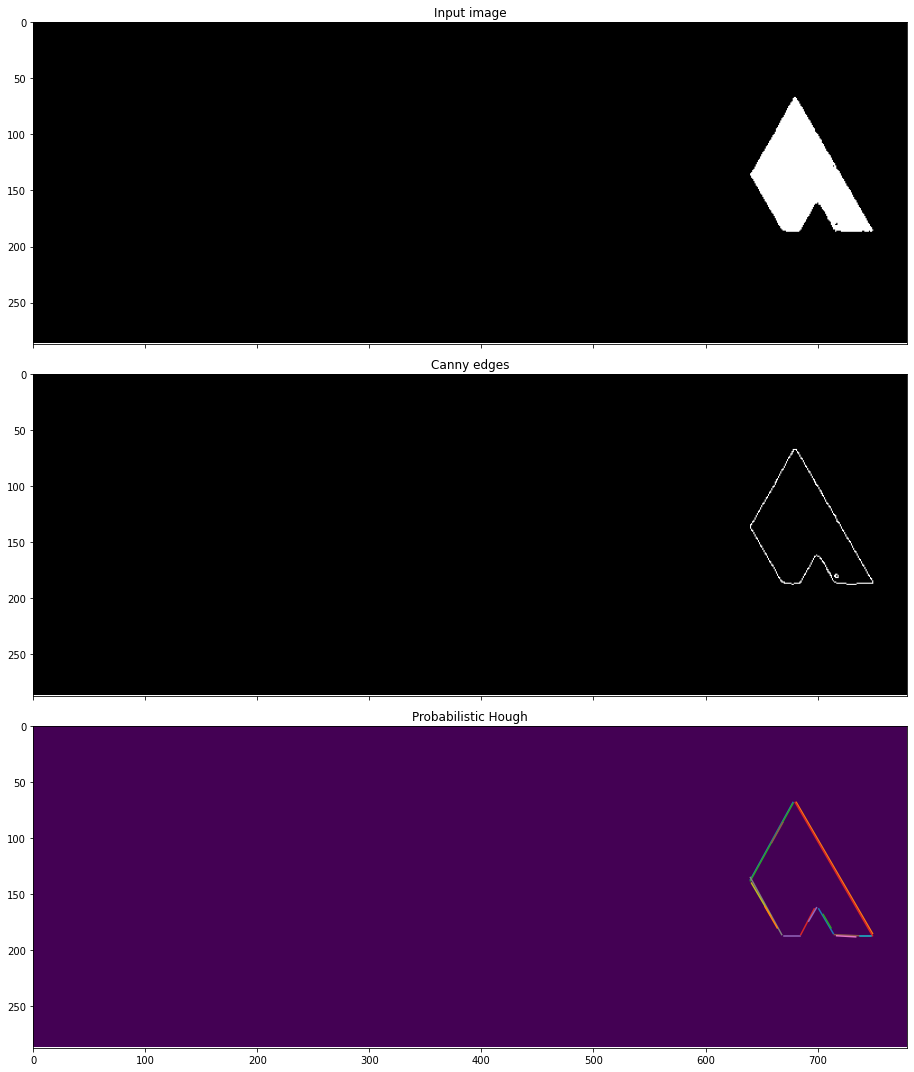

In [88]:
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html
# Line finding using the Probabilistic Hough Transform
image = rgb2gray(regs[0])*255**3/2

edges = canny(image)
#edges = sobel(image)
lines = probabilistic_hough_line(edges, threshold=10, line_length=10,
                                 line_gap=10)

# Generating figure 2
fig, axes = plt.subplots(3,1, figsize=(25, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

#for a in ax:
#    a.set_axis_off()


plt.tight_layout()
plt.show()